# RNA Sequence 3D Backbone Prediction (Stage 1)

## Project Goal

This notebook takes RNA structures stored as atomic coordinates and builds a clean pipeline from **sequence** to a **single 3D backbone point per nucleotide**.
We will:
- Clean and normalize a large Parquet dataset of RNA atoms.
- Derive per-residue backbone centroids (one 3D point per nucleotide).
- Build chain-level sequences with coverage and quality checks.
- Prepare model-ready examples (sequence + backbone coordinates) for learning.
- Train a lightweight baseline that predicts these centroids from sequence alone.

> Stage 1 focuses only on backbone centroids.

> Stage 2 can later expand these into full-atom-like structures using canonical nucleotide templates.

---

### Workflow overview

```mermaid
flowchart TD
    A[Raw RNA atoms (Parquet)] --> B[Milestone 1: Clean & normalize, map residues to A/U/G/C, compute backbone centroids]
    B --> C[Milestone 2: EDA(length & coverage distributions,example backbone plots)]
    C --> D[Milestone 3: Feature engineering(sequence tokens + centered coords, mask & metadata, save NPZ)]
    D --> E[Milestone 4: Train/Val/Test split by pdb_id, no leakage]
    E --> F[Milestone 5: Baseline models\nBiGRU (and later Transformer),predict backbone coords]
```



In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path("data") / "rna_atoms.parquet"

df = pd.read_parquet(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

Shape: (43300393, 8)


,pdb_id,chain_id,residue_name,residue_number,atom_name,x,y,z
0,1AV6,B,G,402,O5',12.905,53.063000,76.258003
1,1AV6,B,G,402,C5',11.989,53.695000,77.120003
2,1AV6,B,G,402,C4',12.146,53.278000,78.540001
3,1AV6,B,G,402,O4',12.764,54.224998,79.453003
4,1AV6,B,G,402,C3',10.729,53.180000,78.959000


## Milestone 1: Data Cleaning & Preparation

Goal: turn raw atomic coordinates into clean, residue-level data that we can safely model.

We will:
- Standardize identifiers and remove duplicate atomic rows.
- Map `residue_name` to canonical bases A/U/G/C and drop unknowns.
- Build residue- and chain-level tables with backbone centroids and sequences.
- Compute chain length and centroid coverage as quality metrics and keep only high-coverage chains (coverage  0.85).

Parquet is used throughout for performance and streaming, avoiding loading any CSV into memory unless explicitly needed.

In [3]:
# Standardize columns
df["pdb_id"] = df["pdb_id"].astype(str)
df["chain_id"] = df["chain_id"].astype(str)
df["residue_name"] = df["residue_name"].astype(str).str.upper().str.strip()
df["atom_name"] = df["atom_name"].astype(str).str.strip()

# Remove exact duplicate rows
before = len(df)
df = df.drop_duplicates()
after = len(df)

print("Removed duplicates:", before - after)

Removed duplicates: 0


In [4]:
RES_MAP = {
    "A":"A","ADE":"A",
    "U":"U","URA":"U","PSU":"U",
    "G":"G","GUA":"G",
    "C":"C","CYT":"C",
}

df["base"] = df["residue_name"].map(RES_MAP)

# Remove residues we cannot interpret
df = df[~df["base"].isna()].copy()

print("Remaining rows after residue filtering:", len(df))

Remaining rows after residue filtering: 26575857


In [5]:
residues = (
    df[["pdb_id","chain_id","residue_number","base"]]
    .drop_duplicates()
    .sort_values(["pdb_id","chain_id","residue_number"])
)

print("Total unique residues:", len(residues))
display(residues.head())

Total unique residues: 1220718


,pdb_id,chain_id,residue_number,base
0,1AV6,B,402,G
24,1AV6,B,403,A
49,1AV6,B,404,A
74,1AV6,B,405,A
99,1AV6,B,406,A


In [6]:
seq_df = (
    residues.groupby(["pdb_id","chain_id"], as_index=False)
    .agg(
        L=("residue_number","count"),
        sequence=("base", lambda s: "".join(s.tolist()))
    )
)

print("Unique PDBs:", seq_df["pdb_id"].nunique())
print("Total chains:", len(seq_df))

display(seq_df["L"].describe())
display(seq_df.head())

Unique PDBs: 521
Total chains: 2155


count    2155.000000
mean      566.458469
std       970.447179
min         1.000000
25%        13.000000
50%        71.000000
75%       122.000000
max      3171.000000
Name: L, dtype: float64

,pdb_id,chain_id,L,sequence
0,1AV6,B,6,GAAAAA
1,1B23,R,69,GGCGCGUAACAAAGCGGAUGUAGCGGAUUGCAAUCCGUCUAGUCCG...
2,1CVJ,M,9,AAAAAAAAA
3,1CVJ,N,7,AAAAAAA
4,1CVJ,O,7,AAAAAAA


In [7]:
BACKBONE_ATOMS = {
    "P",
    "O5'", "O5*",
    "C5'", "C5*",
    "C4'", "C4*",
    "C3'", "C3*",
    "O3'", "O3*",
}

bb = df[df["atom_name"].isin(BACKBONE_ATOMS)].copy()

centroids = (
    bb.groupby(["pdb_id","chain_id","residue_number"], as_index=False)[["x","y","z"]]
      .mean()
      .rename(columns={"x":"cx","y":"cy","z":"cz"})
)

print("Centroid rows:", len(centroids))
display(centroids.head())

Centroid rows: 1215412


,pdb_id,chain_id,residue_number,cx,cy,cz
0,1AV6,B,402,11.605400,53.008400,77.893402
1,1AV6,B,403,6.980333,51.150665,80.477997
2,1AV6,B,404,1.337667,51.647503,80.610664
3,1AV6,B,405,-4.608833,51.256001,79.394501
4,1AV6,B,406,-10.673333,52.386501,79.106834


In [8]:
coverage = residues.merge(
    centroids,
    on=["pdb_id","chain_id","residue_number"],
    how="left"
)

coverage["has_coord"] = (~coverage["cx"].isna()).astype(int)

cov_chain = (
    coverage.groupby(["pdb_id","chain_id"], as_index=False)
    .agg(
        residues=("residue_number","count"),
        with_coords=("has_coord","sum")
    )
)

cov_chain["coverage"] = cov_chain["with_coords"] / cov_chain["residues"]

display(cov_chain["coverage"].describe())
display(cov_chain.sort_values("coverage").head())

count    2155.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: coverage, dtype: float64

,pdb_id,chain_id,residues,with_coords,coverage
0,1AV6,B,6,6,1.0
1,1B23,R,69,69,1.0
2,1CVJ,M,9,9,1.0
3,1CVJ,N,7,7,1.0
4,1CVJ,O,7,7,1.0


In [9]:
GOOD_THRESHOLD = 0.85

good_chains = cov_chain[cov_chain["coverage"] >= GOOD_THRESHOLD][["pdb_id","chain_id"]]

print("Chains kept:", len(good_chains))

# Filter dataset
residues_good = residues.merge(good_chains, on=["pdb_id","chain_id"])
centroids_good = centroids.merge(good_chains, on=["pdb_id","chain_id"])
seq_df_good = seq_df.merge(good_chains, on=["pdb_id","chain_id"])

print("Final usable chains:", len(seq_df_good))
display(seq_df_good["L"].describe())

Chains kept: 2155
Final usable chains: 2155


count    2155.000000
mean      566.458469
std       970.447179
min         1.000000
25%        13.000000
50%        71.000000
75%       122.000000
max      3171.000000
Name: L, dtype: float64

# 2

In [10]:
import numpy as np
import pandas as pd

# Token mapping
TOK = {"A":0, "U":1, "G":2, "C":3}

# Merge base onto centroids so each centroid row has the nucleotide base
centroids_with_base = centroids.merge(
    residues[["pdb_id","chain_id","residue_number","base"]],
    on=["pdb_id","chain_id","residue_number"],
    how="inner"
)

print("Centroids with base:", centroids_with_base.shape)
display(centroids_with_base.head())

Centroids with base: (1220718, 7)


,pdb_id,chain_id,residue_number,cx,cy,cz,base
0,1AV6,B,402,11.605400,53.008400,77.893402,G
1,1AV6,B,403,6.980333,51.150665,80.477997,A
2,1AV6,B,404,1.337667,51.647503,80.610664,A
3,1AV6,B,405,-4.608833,51.256001,79.394501,A
4,1AV6,B,406,-10.673333,52.386501,79.106834,A


In [11]:
def build_chain_example(chain_df: pd.DataFrame):
    """
    chain_df columns: pdb_id, chain_id, residue_number, base, cx, cy, cz
    Output: dict with tokens (L,), coords (L,3), mask (L,), sequence str
    """
    chain_df = chain_df.sort_values("residue_number")

    bases = chain_df["base"].tolist()
    tokens = np.array([TOK[b] for b in bases], dtype=np.int64)

    coords = chain_df[["cx","cy","cz"]].to_numpy(dtype=np.float32)

    # Center only (best choice)
    coords = coords - coords.mean(axis=0, keepdims=True)

    mask = np.ones(len(tokens), dtype=np.uint8)
    seq = "".join(bases)

    return {
        "tokens": tokens,
        "coords": coords,
        "mask": mask,
        "sequence": seq,
        "L": int(len(tokens)),
    }

# Build examples
examples = []
grouped = centroids_with_base.groupby(["pdb_id","chain_id"], sort=False)

for (pdb_id, chain_id), g in grouped:
    ex = build_chain_example(g)
    ex["pdb_id"] = pdb_id
    ex["chain_id"] = chain_id
    examples.append(ex)

print("Total examples (chains):", len(examples))
print("Example keys:", examples[0].keys())
print("One example shapes:", examples[0]["tokens"].shape, examples[0]["coords"].shape, examples[0]["mask"].shape)
print("Sequence preview:", examples[0]["sequence"][:60])

Total examples (chains): 2155
Example keys: dict_keys(['tokens', 'coords', 'mask', 'sequence', 'L', 'pdb_id', 'chain_id'])
One example shapes: (6,) (6, 3) (6,)
Sequence preview: GAAAAA


In [12]:
lengths = np.array([ex["L"] for ex in examples])
print("Chains:", len(lengths))
print("Total residues:", lengths.sum())
print("Length stats:", np.min(lengths), np.median(lengths), np.max(lengths))

# Check coords centered ~0 mean
means = np.stack([ex["coords"].mean(axis=0) for ex in examples[:200]])
print("Mean coord (first 200 chains):", means.mean(axis=0))

Chains: 2155
Total residues: 1220718
Length stats: 1 71.0 3171
Mean coord (first 200 chains): [-5.8221218e-07 -2.6066989e-09 -3.9715866e-07]


In [13]:
import numpy as np
import pandas as pd

lengths = np.array([ex["L"] for ex in examples])

bins = [0, 25, 50, 100, 200, 400, 800, 1600, 10_000]
labels = ["1-25","26-50","51-100","101-200","201-400","401-800","801-1600","1601+"]

bucket = pd.cut(lengths, bins=bins, labels=labels, right=True)
bucket_counts = pd.Series(bucket).value_counts().sort_index()

display(bucket_counts)
print("Longest chains (top 10):")
display(pd.Series(lengths).sort_values(ascending=False).head(10))

1-25        716
26-50        72
51-100      555
101-200     294
201-400       0
401-800       0
801-1600    233
1601+       285
Name: count, dtype: int64

Longest chains (top 10):


1738    3171
557     3150
549     3150
545     3149
553     3149
1754    3149
1762    3149
1750    3147
1766    3136
1746    3134
dtype: int64

In [14]:
from pathlib import Path
import numpy as np

OUT_DIR = Path("out_npz")
OUT_DIR.mkdir(exist_ok=True)

saved = 0
for ex in examples:
    key = f"{ex['pdb_id']}_{ex['chain_id']}"
    out = OUT_DIR / f"{key}.npz"
    np.savez_compressed(
        out,
        pdb_id=ex["pdb_id"],
        chain_id=ex["chain_id"],
        sequence=ex["sequence"],
        tokens=ex["tokens"],
        coords=ex["coords"],
        mask=ex["mask"],
        L=np.int32(ex["L"]),
    )
    saved += 1

print("Saved:", saved, "files to", OUT_DIR)

Saved: 2155 files to out_npz


# 3

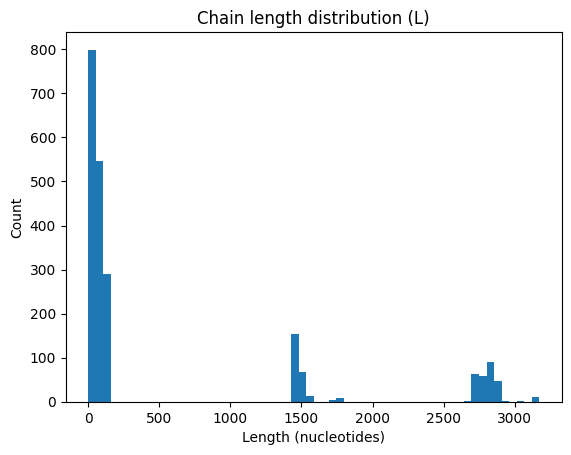

,base,count,pct
0,G,425512,34.86
2,C,322677,26.43
1,A,275596,22.58
3,U,196933,16.13


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# From examples list (already built)
lengths = np.array([ex["L"] for ex in examples])
seqs = [ex["sequence"] for ex in examples]

# Length plot
plt.figure()
plt.hist(lengths, bins=60)
plt.title("Chain length distribution (L)")
plt.xlabel("Length (nucleotides)")
plt.ylabel("Count")
plt.show()

# Base counts
from collections import Counter
base_counts = Counter("".join(seqs))
base_df = pd.DataFrame({"base": list(base_counts.keys()), "count": list(base_counts.values())})
base_df["pct"] = (base_df["count"] / base_df["count"].sum() * 100).round(2)
display(base_df.sort_values("count", ascending=False))

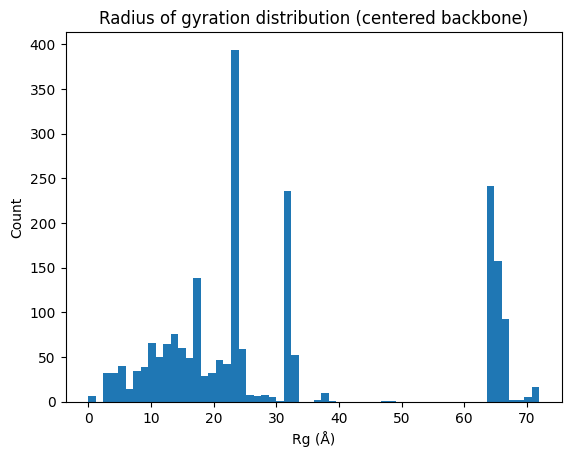

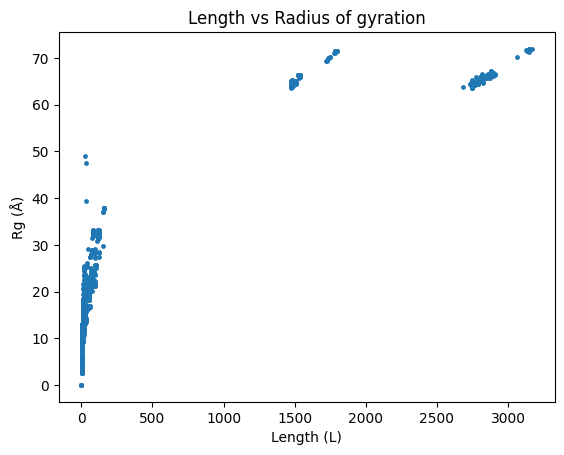

count    2155.000000
mean       30.908512
std        20.750542
min         0.000000
25%        16.261788
50%        23.592520
75%        33.155245
max        71.956764
dtype: float64


In [17]:
def radius_of_gyration(coords: np.ndarray) -> float:
    # coords assumed centered
    return float(np.sqrt((coords**2).sum(axis=1).mean()))

rgs = np.array([radius_of_gyration(ex["coords"]) for ex in examples], dtype=np.float32)

plt.figure()
plt.hist(rgs, bins=60)
plt.title("Radius of gyration distribution (centered backbone)")
plt.xlabel("Rg (Å)")
plt.ylabel("Count")
plt.show()

# Relationship: length vs compactness
plt.figure()
plt.scatter(lengths, rgs, s=6)
plt.title("Length vs Radius of gyration")
plt.xlabel("Length (L)")
plt.ylabel("Rg (Å)")
plt.show()

print(pd.Series(rgs).describe())

In [18]:
import plotly.graph_objects as go
import random

BASE_COLORS = {"A":"#2ecc71","U":"#e74c3c","G":"#f39c12","C":"#3498db"}  # green, red, orange, blue

def plot_chain_3d(ex, title=""):
    coords = ex["coords"]
    seq = ex["sequence"]
    colors = [BASE_COLORS.get(b, "#95a5a6") for b in seq]

    fig = go.Figure()

    # backbone line
    fig.add_trace(go.Scatter3d(
        x=coords[:,0], y=coords[:,1], z=coords[:,2],
        mode="lines",
        line=dict(width=7, color="rgba(80,80,80,0.6)"),
        name="Backbone"
    ))

    # beads
    fig.add_trace(go.Scatter3d(
        x=coords[:,0], y=coords[:,1], z=coords[:,2],
        mode="markers",
        marker=dict(size=5, color=colors, opacity=0.95),
        name="Residues",
        hovertext=[f"{b}{i+1}" for i,b in enumerate(seq)],
        hoverinfo="text"
    ))

    fig.update_layout(
        title=title,
        scene=dict(aspectmode="data"),
        margin=dict(l=0,r=0,t=40,b=0)
    )
    fig.show()

# pick 3 chains: short, medium, long
short = min(examples, key=lambda e: abs(e["L"]-20))
med   = min(examples, key=lambda e: abs(e["L"]-100))
long  = min(examples, key=lambda e: abs(e["L"]-1500))

plot_chain_3d(short, title=f"Short chain: {short['pdb_id']}_{short['chain_id']} (L={short['L']})")
plot_chain_3d(med,   title=f"Medium chain: {med['pdb_id']}_{med['chain_id']} (L={med['L']})")
plot_chain_3d(long,  title=f"Long chain: {long['pdb_id']}_{long['chain_id']} (L={long['L']})")

# 4

In [19]:
import random
from collections import defaultdict

# Unique pdb_ids
all_pdbs = sorted({ex["pdb_id"] for ex in examples})

random.seed(42)
random.shuffle(all_pdbs)

n = len(all_pdbs)
train_pdbs = set(all_pdbs[:int(0.7*n)])
val_pdbs   = set(all_pdbs[int(0.7*n):int(0.85*n)])
test_pdbs  = set(all_pdbs[int(0.85*n):])

train = [ex for ex in examples if ex["pdb_id"] in train_pdbs]
val   = [ex for ex in examples if ex["pdb_id"] in val_pdbs]
test  = [ex for ex in examples if ex["pdb_id"] in test_pdbs]

print("Train chains:", len(train))
print("Val chains:", len(val))
print("Test chains:", len(test))

print("Train residues:", sum(ex["L"] for ex in train))
print("Val residues:", sum(ex["L"] for ex in val))
print("Test residues:", sum(ex["L"] for ex in test))

Train chains: 1553
Val chains: 320
Test chains: 282
Train residues: 871493
Val residues: 188803
Test residues: 160422


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RNADataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        return (
            torch.tensor(ex["tokens"], dtype=torch.long),
            torch.tensor(ex["coords"], dtype=torch.float32),
            torch.tensor(ex["mask"], dtype=torch.float32),
        )

In [21]:
def collate_fn(batch):
    tokens, coords, masks = zip(*batch)

    max_len = max(t.shape[0] for t in tokens)

    padded_tokens = []
    padded_coords = []
    padded_masks = []

    for t, c, m in zip(tokens, coords, masks):
        pad_len = max_len - t.shape[0]

        padded_tokens.append(
            torch.cat([t, torch.zeros(pad_len, dtype=torch.long)])
        )
        padded_coords.append(
            torch.cat([c, torch.zeros(pad_len, 3)])
        )
        padded_masks.append(
            torch.cat([m, torch.zeros(pad_len)])
        )

    return (
        torch.stack(padded_tokens),
        torch.stack(padded_coords),
        torch.stack(padded_masks),
    )

In [22]:
train_ds = RNADataset(train)
val_ds   = RNADataset(val)
test_ds  = RNADataset(test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
import torch.nn as nn

class BiGRUModel(nn.Module):
    def __init__(self, vocab_size=4, embed_dim=32, hidden_dim=128):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )

        self.fc = nn.Linear(hidden_dim * 2, 3)

    def forward(self, tokens):
        x = self.embedding(tokens)
        out, _ = self.gru(x)
        coords = self.fc(out)
        return coords

In [ ]:
def masked_mse(pred, target, mask):
    diff = (pred - target) ** 2
    diff = diff.sum(dim=2)  # sum xyz
    diff = diff * mask
    return diff.sum() / mask.sum()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiGRUModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(loader):
    model.train()
    total_loss = 0
    for tokens, coords, mask in loader:
        tokens = tokens.to(device)
        coords = coords.to(device)
        mask   = mask.to(device)

        pred = model(tokens)
        loss = masked_mse(pred, coords, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def eval_epoch(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for tokens, coords, mask in loader:
            tokens = tokens.to(device)
            coords = coords.to(device)
            mask   = mask.to(device)

            pred = model(tokens)
            loss = masked_mse(pred, coords, mask)
            total_loss += loss.item()

    return total_loss / len(loader)

for epoch in range(10):
    train_loss = train_epoch(train_loader)
    val_loss   = eval_epoch(val_loader)

    print(f"Epoch {epoch+1} | Train {train_loss:.4f} | Val {val_loss:.4f}")

Epoch 1 | Train 3868.2772 | Val 3614.0462
Epoch 2 | Train 3674.6390 | Val 3270.7198
Epoch 3 | Train 3227.2577 | Val 3046.2767
Epoch 4 | Train 3178.9398 | Val 2976.6164
Epoch 5 | Train 3104.0103 | Val 2921.4772
Epoch 6 | Train 3011.7885 | Val 2884.6466
Epoch 7 | Train 2942.4508 | Val 2863.7511
Epoch 8 | Train 2956.3157 | Val 2823.5842
Epoch 9 | Train 2991.5377 | Val 2904.3387
Epoch 10 | Train 2916.8145 | Val 2789.7386


In [26]:
import torch

def masked_rmsd(pred, target, mask):
    """
    pred/target: (B, L, 3)
    mask: (B, L) with 1 for valid positions
    Returns: scalar RMSD in Å (masked)
    """
    diff2 = (pred - target) ** 2          # (B,L,3)
    diff2 = diff2.sum(dim=2)              # (B,L)
    diff2 = diff2 * mask                  # mask padding
    mse = diff2.sum() / mask.sum()
    return torch.sqrt(mse)

In [27]:
def eval_epoch(loader):
    model.eval()
    total_loss = 0.0
    total_rmsd = 0.0
    n_batches = 0

    with torch.no_grad():
        for tokens, coords, mask in loader:
            tokens = tokens.to(device)
            coords = coords.to(device)
            mask   = mask.to(device)

            pred = model(tokens)

            loss = masked_mse(pred, coords, mask)
            rmsd = masked_rmsd(pred, coords, mask)

            total_loss += loss.item()
            total_rmsd += rmsd.item()
            n_batches += 1

    return total_loss / n_batches, total_rmsd / n_batches

In [28]:
val_loss, val_rmsd = eval_epoch(val_loader)
print(f"VAL | loss={val_loss:.2f} | RMSD={val_rmsd:.2f} Å")

VAL | loss=2789.74 | RMSD=51.59 Å


In [29]:
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loss, test_rmsd = eval_epoch(test_loader)
print(f"TEST | loss={test_loss:.2f} | RMSD={test_rmsd:.2f} Å")

TEST | loss=2587.25 | RMSD=50.41 Å
